In [6]:
import sys
sys.path.append('..')
from pcutils.core.config import load_config
from pcutils.core.workspace import Workspace
from pcutils.core.nuclear_data import NucleusData
from pcutils.plot.histogram import Histogrammer
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
from scipy import constants

QBRHO_2_P: float = 1.0e-9 * constants.speed_of_light * 100.0 * 10.0 #T * m -> MeV/c

In [7]:
config = load_config('../local_config.json')
ws = Workspace(config.workspace)
nuclear_map = ws.get_nuclear_map()
ejectile = nuclear_map.get_data(1, 2)
projectile = nuclear_map.get_data(6, 16)
target = nuclear_map.get_data(1, 2)
residual = nuclear_map.get_data(6, 16)

In [8]:
df = pl.read_parquet(ws.get_physics_file_path_parquet(4, ejectile))
grammer = Histogrammer()
grammer.add_hist2d('ke_theta', (180, 100), ((0.0, 180.0), (0.0, 10.0)))
grammer.add_hist2d('ke_phi', (360, 100), ((0.0, 360.0), (0.0, 10.0)))
grammer.add_hist1d('ex', 1000, (0.0, 10.0))

In [9]:
momentum = df.select('brho').to_numpy() * float(ejectile.Z) * QBRHO_2_P
kinetic_energy = np.sqrt(momentum**2.0 + ejectile.mass**2.0) - ejectile.mass
polar = np.rad2deg(df.select('polar').to_numpy())
az = np.rad2deg(df.select('azimuthal').to_numpy())
grammer.fill_hist2d('ke_theta', polar, kinetic_energy)
grammer.fill_hist2d('ke_phi', az, kinetic_energy)

True

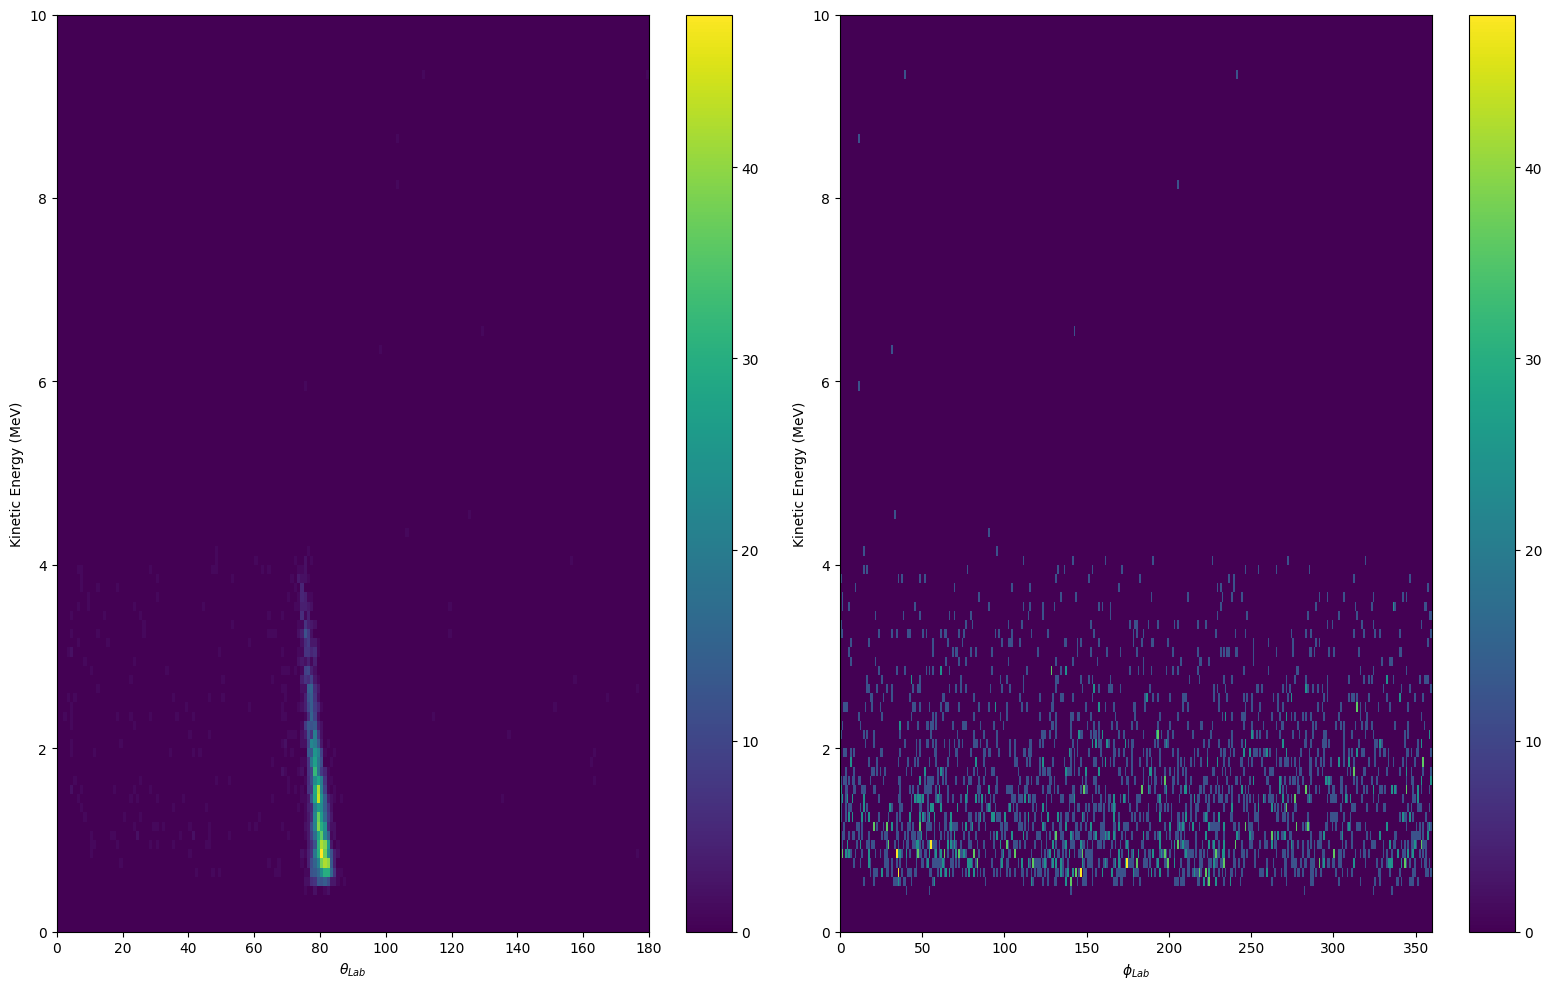

In [10]:
fig, ax = plt.subplots(1,2)
fig.set_figwidth(16)
fig.set_figheight(10)
mesh = grammer.draw_hist2d('ke_theta', ax[0], log_z=False)
ax[0].set_xlabel(r'$\theta_{Lab}$')
ax[0].set_ylabel('Kinetic Energy (MeV)')
plt.colorbar(mesh, ax=ax[0])
mesh2 = grammer.draw_hist2d('ke_phi', ax[1], log_z=False)
ax[1].set_xlabel(r'$\phi_{Lab}$')
ax[1].set_ylabel('Kinetic Energy (MeV)')
plt.colorbar(mesh, ax=ax[1])
plt.tight_layout()